This is the development notebook to find a way to get the size at which the 50 and 95 percentile of the heating has been found.

In [1]:
import scipy.integrate
import pickle
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

%matplotlib inline

$$ \int_{a}^{b}f(x)dx \approx \sum_{k=1}^{N} \frac{f(x_{k-1}+f(x_{k}))}{2}\Delta x_{k} $$

In [2]:
filename = "TotaHeating.pkl"
data_dir = "/Users/juan/codes/run/PeHeating"
pkl_file = open("%s/%s"%(data_dir, filename), "rb")
PeH_dict = pickle.load(pkl_file)
pkl_file.close

<function close>

In [3]:
PeH_dict.keys()

['nH',
 'G_CR',
 'new_xe',
 'PeHtot',
 'cell_mass',
 'NH2',
 'ne',
 'xe',
 'Geff',
 'Ntot',
 'info',
 'Gtot',
 'temp',
 'Av',
 'new_ne',
 'zeta',
 'MPI',
 'nH2',
 'fH2shield']

/Users/juan/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


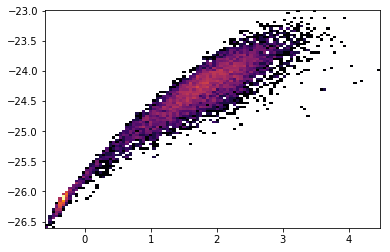

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist2d(np.log10(PeH_dict["nH"]), np.log10(PeH_dict["PeHtot"]), norm=LogNorm(), cmap="inferno", bins=100)

fig.show()

In [5]:
## Let's say that I already have the data loaded.

In [6]:
import parametric_PeHeat as parPeH

In [90]:
def get_percentiles(Gtot, temp, ne, amin=3.5, amax=2500, numint=100):
    """
    This function finds the grain size where the 50 and 95 percentile of the photoelectric heating has been reached.
    
    Integrates the total photoelectric heating rate using the trapezium method and checks if the percentile has been reached.

    Returns:
        size50perc, size95perc.
    """
    import dust_size_dist as sizedist
    import numpy as np
    import parametric_PeHeat as parPeH
    
    #Gammatot = parPeH.get_Gamma_tot(Gtot, temp, ne, amin=amin, amax=amax)
    
    x = np.logspace(np.log10(amin), np.log10(amax), num=numint)
    yc = sizedist.dnda(x, "carbonaceous")
    ys = sizedist.dnda(x, "silicate")
    
    y_Gpe_s = np.zeros(numint, dtype=np.float)
    y_Gpe_c = np.zeros(numint, dtype=np.float)

    for j in range(numint):
        #print(j)
        y_Gpe_s[j] = parPeH.get_Gamma_dot(Gtot, temp, ne, x[j], "silicate")*sizedist.dnda(x[j], "silicate")*1.0e21
        y_Gpe_c[j] = parPeH.get_Gamma_dot(Gtot, temp, ne, x[j], "carbonaceous")*sizedist.dnda(x[j], "carbonaceous")*1.0e21    
        
    Gamma_tot_k = 0
    k = 1
    
    totd_s_fix = np.trapz(y_Gpe_s, x)
    totd_c_fix = np.trapz(y_Gpe_c, x)
    
    Gammatot_trapz = totd_s_fix + totd_c_fix
    
    #print("Using Trapezium rule:", (totd_s_fix+totd_c_fix)/1.0e21)
    
    perc50 = False
    perc95 = False
    
    asize50perc = -1
    asize95perc = -1
    
    while perc95 == False:
        #integrate
        #print(k)
        deltax = x[k] - x[k-1]
        Gamma_tot_k += (y_Gpe_s[k-1] + y_Gpe_s[k])/2.0*deltax + (y_Gpe_c[k-1] + y_Gpe_c[k])/2.0*deltax
        #print(Gamma_tot_k)
        
        # look for the 50th percentile
        if (Gamma_tot_k) >= 0.5*Gammatot_trapz and perc50 == False:
            asize50perc = x[k]
            perc50 = True
            #print("Found the 50th percentile. size", x[k])
            #print("Gammatot = %.2g"%Gammatot_trapz)
            #print("Current PeHeat = %.2g"%Gamma_tot_k)
            
        # look for the 95th percentile
        if (Gamma_tot_k) >= 0.95*Gammatot_trapz and perc95 == False:
            asize95perc = x[k]
            perc95 = True
            #print("Found the 95th percentile. size", x[k])
            #print("Gammatot = %.2g"%Gammatot_trapz)
            #print("Current PeHeat = %.2g"%Gamma_tot_k)

        if k==numint-1:
            print("Did not find the 95th percentile!!!")
            print("Gammatot = %.2g"%Gammatot)
            print("Current PeHeat = %.2g"%Gamma_tot_k)
            break
            
        k+=1
                
    return asize50perc, asize95perc

In [91]:
# Compute time.

In [92]:
size50, size95 = np.zeros(len(PeH_dict["nH"]), dtype=np.float), np.zeros(len(PeH_dict["nH"]), dtype=np.float)

for i in range(100):
#for i in range(len(PeH_dict["nH"])):
    size50[i], size95[i] = get_percentiles(PeH_dict["Gtot"][i], PeH_dict["temp"][i], PeH_dict["new_ne"][i])

(array([  0.,   0.,   0.,  19.,  46.,  35.,   0.,   0.,   0.,   0.]),
 array([  3.5 ,   4.15,   4.8 ,   5.45,   6.1 ,   6.75,   7.4 ,   8.05,
          8.7 ,   9.35,  10.  ]),
 <a list of 10 Patch objects>)

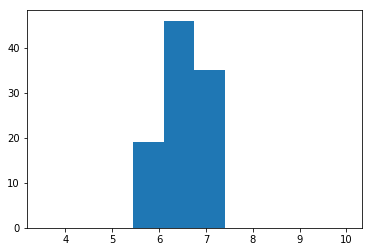

In [98]:
plt.hist(size50,range=[3.5, 10])

---
# Deprecated functions

In [78]:
def get_percentiles_terrible(Gtot, temp, ne, minsize=3.5, maxsize=2500, numint=100, pedantic=False):
    """
    This function finds the grain size where the 50 and 95 percentile of the photoelectric heating has been reached.
    
    Integrates the total photoelectric heating rate using the trapezium method and checks if the percentile has been reached.

    Returns:
        size50perc, size95perc.
    """
    import dust_size_dist as sizedist
    import numpy as np
    import parametric_PeHeat as parPeH
    
    Gammatot = parPeH.get_Gamma_tot(Gtot, temp, ne, amin=minsize, amax=maxsize)
    
    #print(minsize, maxsize, numint)
    x = np.logspace(np.log10(minsize), np.log10(maxsize), num=numint)
    #print(x)
    yc = sizedist.dnda(x, "carbonaceous")
    ys = sizedist.dnda(x, "silicate")
    
    #print(x)
    Gamma_tot_k = 0
    k = 1
    
    perc50 = False
    perc95 = False
    
    asize50perc = -1
    asize95perc = -1
    
    while perc95 == False:
    #while k<numint:

        #print(x[k])
        Gammaperc = parPeH.get_Gamma_tot(Gtot, temp, ne, amin=minsize, amax=x[k])
        #print(x[k], Gammaperc)    
        
        # look for the 50th percentile
        if Gammaperc >= 0.5*Gammatot and perc50 == False:
            asize50perc = x[k]
            perc50 = True
            if pedantic:
                print("Found the 50th percentile. size", x[k])
                print("Gammatot = %.2g"%Gammatot)
                print("Current PeHeat = %.2g"%Gammaperc)
            
        # look for the 95th percentile
        if Gammaperc >= 0.95*Gammatot and perc95 == False:
            asize95perc = x[k]
            perc95 = True
            if pedantic:
                print("Found the 95th percentile. size", x[k])
                print("Gammatot = %.2g"%Gammatot)
                print("Current PeHeat = %.2g"%Gammaperc)

        if k==numint-1:
            print("Did not find the 95th percentile!!!")
            print("Gammatot = %.2g"%Gammatot)
            print("Current PeHeat = %.2g"%Gammaperc)
            break  
        k+=1
            
    return asize50perc, asize95perc

---

In [106]:
filename = "Percentiles_0pcent.pkl"
data_dir = "/Users/juan/codes/run/PeHeating"
pkl_file = open("%s/%s"%(data_dir, filename), "rb")
percdict = pickle.load(pkl_file)
pkl_file.close

<function close>

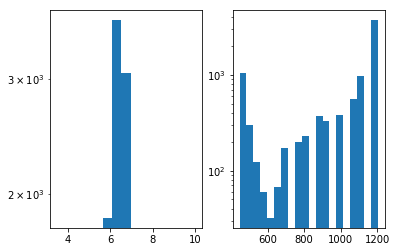

In [116]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.hist(percdict["size50"], range=[3.5,10], bins=15)
ax.set_yscale("log")
fig.show()

ax = fig.add_subplot(122)
ax.hist(percdict["size95"], bins=20)
ax.set_yscale("log")
fig.show()